In [18]:
from openpiv import tools, pyprocess, validation, filters, scaling

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import imageio
import importlib_resources
import pathlib

In [78]:
cap = cv2.VideoCapture("data/slow_car.mp4")
ret, frame = cap.read()
frames = []
while 1:

    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames.append(frame)



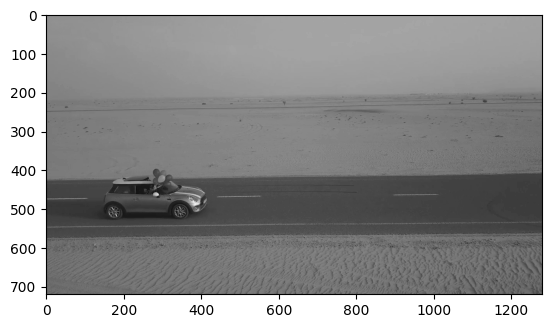

In [79]:
plt.figure()
plt.imshow(frames[101], cmap="gray")

In [14]:
car_data = cv2.CascadeClassifier("./data/cars.xml")

2  cars found


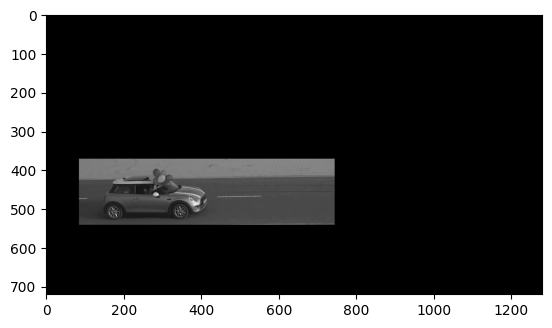

In [108]:
frame = frames[101].copy()
frame_blur = cv2.GaussianBlur(frame, (5, 5), 0)
frame_dilated = cv2.dilate(frame_blur, np.ones((3, 3)))
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
closing = cv2.morphologyEx(frame_dilated, cv2.MORPH_CLOSE, kernel)
cars = car_data.detectMultiScale(closing, 1.1, 1)
cnt = 0
for x, y, w, h in cars:
    frame[y + h :] = 0
    frame[:y - h -50] = 0
    frame[:, x + w + 500 :] = 0
    frame[:, : x -100 ] = 0

    cnt += 1
print(cnt, " cars found")
plt.figure()
plt.imshow(frame, cmap="gray")

In [ ]:



A = 1
winsize = 32  # pixels, interrogation window size in frame A
searchsize = 38  # pixels, search area size in frame B
overlap = 17  # pixels, 50% overlap
dt = 0.02  # sec, time interval between the two frames
cv2.imwrite("frameA.png", frames[50])
u0, v0, sig2noise = pyprocess.extended_search_area_piv(
    frames[50].astype(np.int32),
    frames[51].astype(np.int32),
    window_size=winsize,
    overlap=overlap,
    dt=dt,
    search_area_size=searchsize,
    sig2noise_method="peak2peak",
)

x, y = pyprocess.get_coordinates(
    image_size=frames[50].shape,
    search_area_size=searchsize,
    overlap=overlap,
)
invalid_mask = validation.sig2noise_val(
    sig2noise,
    threshold=1.05,
)

u2, v2 = filters.replace_outliers(
    u0,
    v0,
    invalid_mask,
    method="localmean",
    max_iter=3,
    kernel_size=3,
)

# convert x,y to mm
# convert u,v to mm/sec

x, y, u3, v3 = scaling.uniform(
    x,
    y,
    u2,
    v2,
    scaling_factor=96.52,  # 96.52 pixels/millimeter
)

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)

fig, ax = plt.subplots(figsize=(8, 8))
tools.save("exp1_001.txt", x, y, u3, v3, invalid_mask)
tools.display_vector_field(
    pathlib.Path("exp1_001.txt"),
    ax=ax,
    scaling_factor=96.52,
    scale=50,  # scale defines here the arrow length
    width=0.0035,  # width is the thickness of the arrow
    on_img=True,  # overlay on the image
    image_name="frameA.png",
)
plt.show()